### Notebook to Research diabetes onset 


#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [4]:
%%time
canary_p = '../../../data/CANARY/CANARY/CANARY202104'
pmpm_p = '../../../temp/PMPM.p'
preg_p = '../../../data/pregnancies'

preg = pq.read_table(preg_p).to_pandas()
canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.84 s, sys: 7.1 s, total: 12.9 s
Wall time: 12.8 s


### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

In [5]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [6]:
preg = preg.rename(mapper = {'person_id':'PERS_ID'}, axis = 1)
preg = pd.melt(preg, id_vars = ['PERS_ID'], value_vars=['stay_start_date', 'stay_end_date'], value_name='MYR')
preg.MYR = preg.MYR.apply(lambda x: x.year*100+x.month)
preg.drop(labels = 'variable', axis = 1, inplace = True)
preg['PREGNANCY'] = 1

In [7]:
%%time
pmpm = pmpm.merge(preg, how = 'left', on = ['PERS_ID', 'MYR'])
pmpm.PREGNANCY = pmpm.PREGNANCY.fillna(value = 0)
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)

CPU times: user 12.4 s, sys: 7.64 s, total: 20 s
Wall time: 20 s


In [8]:
from utils import ip_er2

In [9]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = ((pmpm.ALLOW_IP>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ER_BIN'] = ((pmpm.ALLOW_ER>0) & (pmpm.PREGNANCY == 0)).astype(int)

CPU times: user 7.21 s, sys: 2.77 s, total: 9.98 s
Wall time: 9.98 s


In [10]:
%%time

pmpm = pmpm.groupby('PERS_ID', sort = False).apply(ip_er2, time = 6).reset_index(drop = True)

CPU times: user 28min 22s, sys: 18 s, total: 28min 40s
Wall time: 28min 37s


### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [11]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 7.7 s, sys: 3.2 s, total: 10.9 s
Wall time: 10.9 s


Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [12]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 5.35 s, sys: 8.06 ms, total: 5.35 s
Wall time: 5.35 s


#### Hierarchical Clustering
> Divide the Treated population in two clusters and study the <strong>Onset of Diabetes Onset</strong> separately in each of the clusters

In [13]:
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

treated0, treated1, model, link_matr,  clustermapdat = agglomerative(treated2.copy(), columns_to_match )

#### Visualization of the clusters created in the previous step with a clustermap

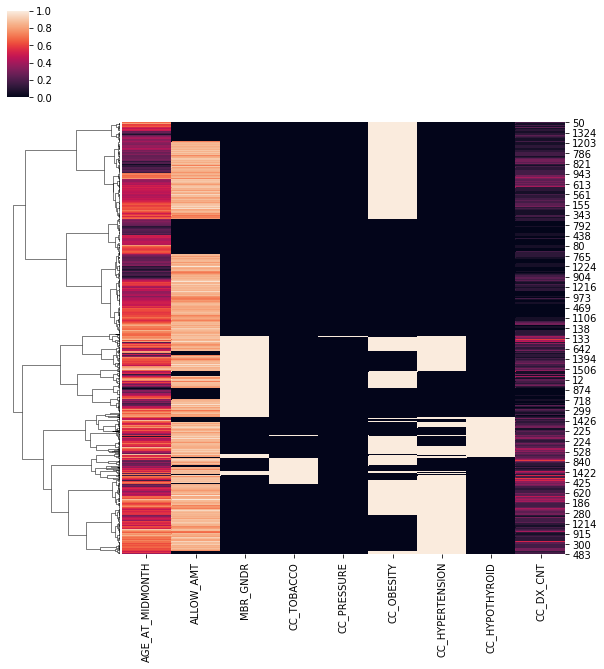

In [14]:
g = sns.clustermap(clustermapdat, method = 'ward', standard_scale=1, row_linkage = link_matr, col_cluster = False)

#### For each of the two clusters formed from the Treated patients form a matched population from the controls.
<div style="background:Aliceblue"> We use propensity score matching as our matching function</div>

In [15]:
%%time

columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2', 'LOB']
hier_cols = ['IP_BIN2', 'ER_BIN2', 'LOB']
hier_range = [1,1, 0]
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5}
matched0, matched_data0 = matched_population(treated0.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

matched1, matched_data1 = matched_population(treated1.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)


Mathcing Function: nearest_neighbor_func
Mathcing Function: nearest_neighbor_func
CPU times: user 49min 14s, sys: 25min 47s, total: 1h 15min 1s
Wall time: 1h 15min 1s


####  In addition to the previously created matched groups create a random group

In [16]:
random_matching_func_args = {'neighbors_per_treated': 100}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [17]:
Path('./tempNNhier').mkdir(exist_ok = True)
p = './tempNNhier/'
matched_data0.to_pickle(p+'match0.p')
matched_data1.to_pickle(p+'match1.p')
random_controls.to_pickle(p+'random.p')
treated0.to_pickle(p+'treated0.p')
treated1.to_pickle(p+'treated1.p')

In [18]:
p = './tempNNhier/'

matched_data0 = pd.read_pickle(p+'match0.p')
matched_data1 = pd.read_pickle(p+'match1.p')
random_controls = pd.read_pickle(p+'random.p')
treated0 = pd.read_pickle(p+'treated0.p')
treated1 = pd.read_pickle(p+'treated1.p')

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [19]:
%%time
con_onset0 = diabet_onset(matched_data0.copy(), 'Diabetes_Con0')
con_onset1 = diabet_onset(matched_data1.copy(), 'Diabetes_Con1')

treated_onset0 = diabet_onset(treated0.copy(), 'Diabetes_Tr')
treated_onset1 = diabet_onset(treated1.copy(), 'Diabetes_Tr')

pmpm2 = filter_first_month_diabetes(pmpm.copy())
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM')

CPU times: user 4min 12s, sys: 10.7 s, total: 4min 22s
Wall time: 4min 20s


In [20]:
random_onset = diabet_onset(random_controls.copy(), 'Diabetes_Rnd')

In [21]:
con_onset20 = con_onset0.rename(columns = {'Sample': 'Sample_Con0', 'Per_1000':'Per_1000_Con0'})
con_onset21 = con_onset1.rename(columns = {'Sample': 'Sample_Con1', 'Per_1000':'Per_1000_Con1'})

treated_onset20 = treated_onset0.rename(columns = {'Sample': 'Sample_Tr0', 'Per_1000':'Per_1000_Tr0'})
treated_onset21 = treated_onset1.rename(columns = {'Sample': 'Sample_Tr1', 'Per_1000':'Per_1000_Tr1'})

pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

In [22]:
random_onset2 = random_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})
joint = pd.concat((con_onset20, con_onset21, treated_onset20, treated_onset21,  pmpm_onset2, random_onset2), axis = 1)

### Diabetes Onset Per Month Statistics

1. **_Con{i} : For Matched Controls Population**
2.  **_Tr{i} : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**
4. **_Rnd: For a Random Matching**

>Sample_: The number of patients per month  
Diabetes_: The number of patients with Diabetes Onset in a month  
Per_1000_: The number of patients with Diabetes Onset in a a month per 1000  


In [23]:
joint.describe().loc[['mean', 'std']]

Sample_Con0  Diabetes_Con0  Per_1000_Con0  Sample_Con1  Diabetes_Con1  Per_1000_Con1  Sample_Tr0  Diabetes_Tr  Per_1000_Tr0  Sample_Tr1  Diabetes_Tr  Per_1000_Tr1      Sample_PM  Diabetes_PM  Per_1000_PM     Sample_PM  Diabetes_Rnd  Per_1000_PM
mean  1235.289474       2.447368       1.879213   855.714286       1.238095       1.236873  267.052632     0.657895      1.944634  237.880952     0.404762      1.080297  143003.882353   279.901961     1.961085  32656.619048     58.023810     1.760473
std   1051.454152       2.489951       1.868434   799.557844       1.494862       1.914551  227.457504     0.937977      4.332846  228.253838     0.700506      1.992007   13718.389511    44.775554     0.272818  28435.537611     50.328428     0.903969

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

In [25]:
joint2 = pd.concat((con_onset0, con_onset1, treated_onset0, treated_onset1,  pmpm_onset, random_onset), axis = 1)
jointcon0 = joint2.Per_1000.iloc[1:, 0].reset_index()
jointcon1 = joint2.Per_1000.iloc[1:, 1].reset_index()
jointTr0 = joint2.Per_1000.iloc[1:, 2].reset_index()

jointTr1 = joint2.Per_1000.iloc[1:, 3].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 4].reset_index()
jointrandom = joint2.Per_1000.iloc[1:, 5].reset_index()


<div style="background:Aliceblue"> 
    <h3> Plot Top Left: $f(x)$ = Onset Per 1000 per month </h3>
    <h3> Plot Top Right and Bottom Left: $F(x) = \int_0^x f(y)dy$ <br>
        Cumulative sum of the rates </h3>
</div>

No handles with labels found to put in legend.


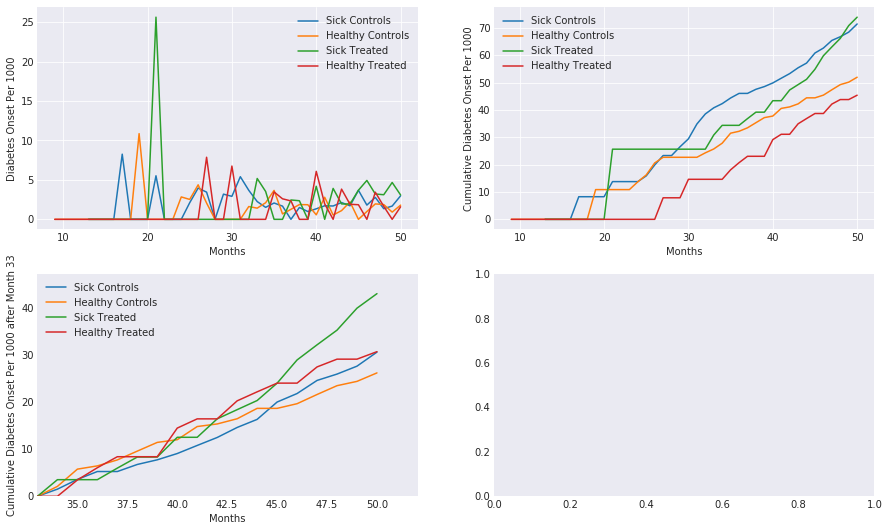

In [26]:
from diabetes_onset_plotter import plot_onset, plot_onset2
names = ['Sick Controls', 'Healthy Controls', 'Sick Treated', 'Healthy Treated']#, 'Random']
f, ax = plot_onset2(jointcon0, jointcon1, jointTr0, jointTr1, names = names)
#f.savefig('figs/onset.png')
plt.show()

In [27]:
a = treated0.groupby(['PERS_ID']).apply(lambda x: pd.Series([x.MBR_GNDR.sum(), len(x)], index = ['GEN', 'LEN'])).reset_index(drop = True)

In [28]:
from utils import statistics_first_month

In [29]:
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [30]:
%%time
tr_desc0, Ntr0 = statistics_first_month(treated0, columns_to_match)
tr_desc0 = tr_desc0.T

tr_desc1, Ntr1 = statistics_first_month(treated1, columns_to_match)
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc1 = tr_desc1.T

con_desc0, Ncon0 = statistics_first_month(matched_data0, columns_to_match)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

con_desc1, Ncon1 = statistics_first_month(matched_data1, columns_to_match)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc1 = con_desc1.T

pmpm_desc, Npmpm = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc, Nrand = statistics_first_month(random_controls, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T


CPU times: user 2min 46s, sys: 2.97 s, total: 2min 49s
Wall time: 2min 49s


In [31]:
import scipy.stats as sts

In [32]:
args0 = {'mean1':tr_desc0['mean'], 'std1':tr_desc0['std'],
        'mean2':con_desc0['mean'], 'std2':con_desc0['std'],
        'nobs1': np.full(len(tr_desc0), Ntr0) , 'nobs2': np.full(len(tr_desc0), Ncon0)}
stats0, pval0 = sts.ttest_ind_from_stats(**args0)
stats0 = pd.DataFrame(stats0, columns = ['t-stat'])
stats0['pval'] = pval0

args1 = {'mean1':tr_desc1['mean'], 'std1':tr_desc1['std'],
        'mean2':con_desc1['mean'], 'std2':con_desc1['std'],
        'nobs1': np.full(len(tr_desc1), Ntr1) , 'nobs2': np.full(len(tr_desc1), Ncon1)}
stats1, pval1 = sts.ttest_ind_from_stats(**args1)
stats1 = pd.DataFrame(stats1, columns = ['t-stat'])
stats1['pval'] = pval1

In [33]:
alli = pd.concat((tr_desc0['mean'], con_desc0['mean'], stats0['pval'], 
                  tr_desc1['mean'], con_desc1['mean'], stats1['pval'],
                  pmpm_desc['mean'], random_desc['mean']),
                 axis = 1, keys = ['Sick Treated','Sick Controls','T-Stats0',
                                   'Healthy Treated', 'Healthy Controls','T-Stats1',
                                   'Genaral Population', 'Random'] )

## Statistics on matching date

In [34]:
alli

Sick Treated  Sick Controls      T-Stats0  Healthy Treated  Healthy Controls  T-Stats1  Genaral Population      Random
AGE_AT_MIDMONTH     53.608640      53.600631  9.865126e-01        46.186418         46.658693  0.348395           43.048583   47.234847
ALLOW_AMT          815.396442     735.185741  5.014794e-01       535.544607        493.587264  0.469872          986.578600  750.230425
MBR_GNDR             0.396442       0.401473  7.932494e-01         0.000000          0.000000       NaN            0.432864    0.425216
CC_TOBACCO           0.124524       0.088661  1.768175e-03         0.000000          0.008760  0.010047            0.072285    0.095953
CC_PRESSURE          0.002541       0.002368  9.278420e-01         0.000000          0.000000       NaN            0.003787    0.005924
CC_OBESITY           0.454892       0.419626  6.860187e-02         0.451398          0.431604  0.328536            0.092396    0.220597
CC_HYPERTENSION      0.627700       0.566956  1.685001e-03         0.000000          0.016173  0.000449            0.174132    0.245384
CC_HYPOTHYROID       0.180432       0.114444  3.630054e-07         0.000000          0.005728  0.037647            0.041370    0.063341
CC_DX_CNT            3.440915       3.370429  4.075831e-01         1.766977          1.744609  0.737038            1.531662    2.298980
IP_BIN2              0.043202       0.044199  9.181170e-01         0.006658          0.006402  0.945984            0.018782    0.045060
ER_BIN2              0.106734       0.107077  9.812045e-01         0.057257          0.056267  0.921719            0.047123    0.123252
LOB                  0.947903       0.946330  8.582057e-01         0.958722          0.957884  0.918553            0.752927    0.785727

In [35]:
tr_desc0 = treated0[columns_to_match].describe().loc[['mean']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0 = tr_desc0.T

tr_desc1 = treated1[columns_to_match].describe().loc[['mean']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc1 = tr_desc1.T

con_desc0 = matched_data0[columns_to_match].describe().loc[['mean']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

con_desc1 = matched_data1[columns_to_match].describe().loc[['mean']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc1 = con_desc1.T

pmpm_desc = pmpm2[columns_to_match].describe().loc[['mean']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc = random_controls[columns_to_match].describe().loc[['mean']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

alli = pd.concat((tr_desc0, tr_desc1, con_desc0, con_desc1, pmpm_desc, random_desc), axis = 1, keys = ['Sick Treated','Healthy Treated',
                                                                                                       'Sick Controls', 'Healthy Controls',

'Genaral Population', 'Random'] )

#### Univariate Means of the Groups under Study of interesting features (Statistics for whole populations)
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [36]:
alli

Sick Treated Healthy Treated Sick Controls Healthy Controls Genaral Population      Random
                        mean            mean          mean             mean               mean        mean
AGE_AT_MIDMONTH    54.036866       46.804141     54.117685        47.344032          48.759167   49.945624
ALLOW_AMT         899.432035      620.566596    806.543306       694.389920         748.531555  740.195295
MBR_GNDR            0.368564        0.000000      0.361665         0.000000           0.421103    0.419869
CC_TOBACCO          0.115681        0.014974      0.095009         0.022843           0.099304    0.103662
CC_PRESSURE         0.004358        0.000000      0.003916         0.001394           0.007168    0.007314
CC_OBESITY          0.472169        0.516868      0.443875         0.458726           0.231656    0.276670
CC_HYPERTENSION     0.565241        0.069507      0.531813         0.077274           0.283097    0.293644
CC_HYPOTHYROID      0.160174        0.026990      0.109483         0.039524           0.069572    0.074754
CC_DX_CNT           3.454372        2.153434      3.448901         2.113883           2.539357    2.723638
IP_BIN2             0.034777        0.013125      0.043150         0.017873           0.047520    0.046379
ER_BIN2             0.097340        0.055828      0.091561         0.069491           0.118977    0.112900
LOB                 0.951875        0.960255      0.940271         0.952109           0.797746    0.803632

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

In [37]:
def plot0():
    fig, ax = plt.subplots(3,3, figsize = (15,9))
    for i in range(3):
        for j in range(3):
            column = columns_to_match[i*3 + j]
            if column == 'ALLOW_AMT':
                treated00 = treated0.copy()
                treated00[column] = np.log(treated00[column].values + 10**(-10))
                matched00 = matched_data0.copy()
                matched00[column] = np.log(matched00[column].values + 10**(-10))

                sns.distplot(treated00[column], ax = ax[i,j])
                sns.distplot(matched00[column], ax = ax[i,j])
                ax[i,j].legend(['S Treated', 'S Controls'])
            else:
                sns.distplot(treated0[column], ax = ax[i,j])
                sns.distplot(matched_data0[column], ax = ax[i, j])
                ax[i,j].legend(['S Treated', 'S Controls'])
                
    return fig, ax

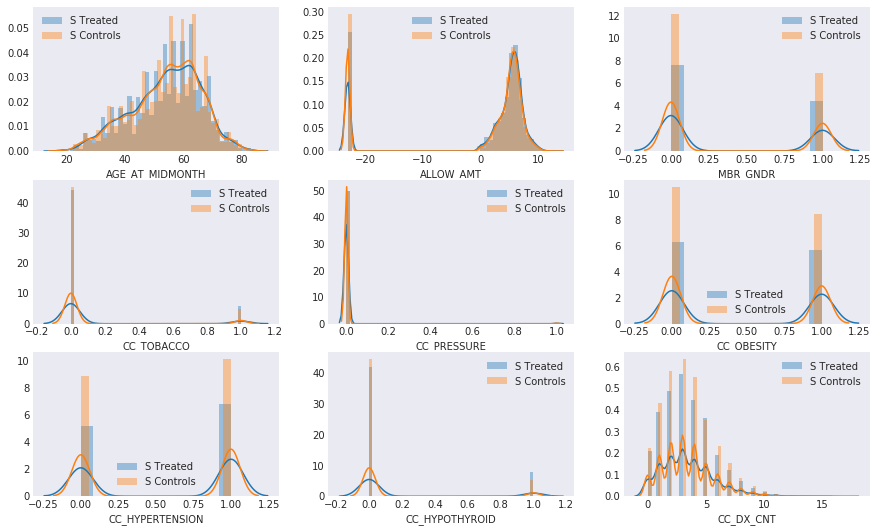

In [38]:
f0, ax0 = plot0()

In [39]:
def plot1():
    fig, ax = plt.subplots(3,3, figsize = (15,9))
    for i in range(3):
        for j in range(3):
            column = columns_to_match[i*3 + j]

            try:
                if column == 'ALLOW_AMT':
                    treated00 = treated1.copy()
                    treated00[column] = np.log(treated00[column].values + 10**(-10))
                    matched00 = matched_data1.copy()
                    matched00[column] = np.log(matched00[column].values + 10**(-10))

                    sns.distplot(treated00[column], ax = ax[i,j])
                    sns.distplot(matched00[column], ax = ax[i,j])
                    ax[i,j].legend(['H Treated', 'H Controls'])
                else:
                    sns.distplot(treated1[column], ax = ax[i,j])
                    sns.distplot(matched_data1[column], ax = ax[i, j])
                    ax[i,j].legend(['H Treated', 'H Controls'])
                    ax.set_title('Bla')
            except:
                continue
    return fig, ax

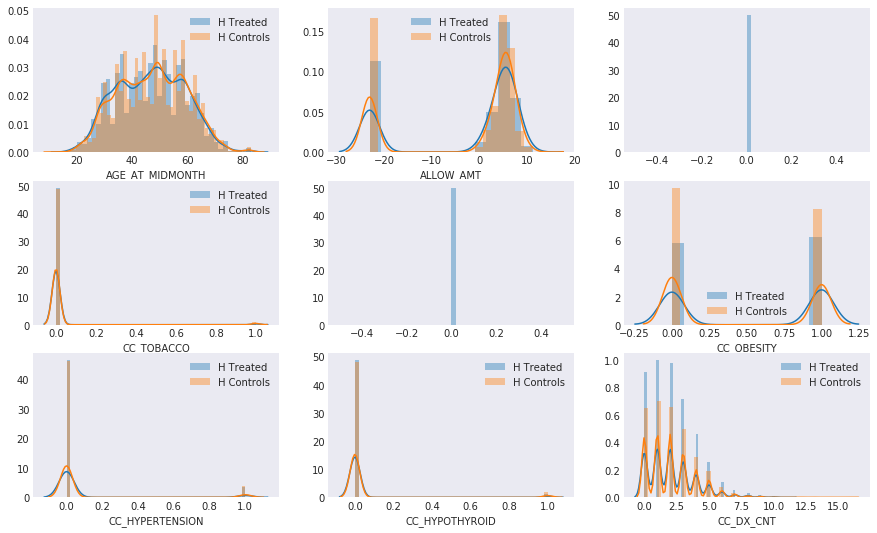

In [40]:
f1, ax1 = plot1()